## Semantic Segmentation

In [3]:
pip install torchnet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 22.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.9/55.9 KB 8.2 MB/s eta 0:00:00
  Created wheel for torchnet: filename=torchnet-0.0.4-py3-none-any.whl size=29745 sha256=ba2e82d688b2cb30edb0b9ff91a398d39175c3a18fc35b851a1591e2e76879f0
  Stored in directory: /root/.cache/pip/wheels/65/d2/1e/0c2519d1837089fe374a60ce10e120c555b9d77110a49f027f
  Created wheel for visdom: filename=visdom-0.2.4-py3-none-any.whl size=1408216 sha256=2ae2f153e6ceeeee8c60a64bc77af9a2a41ae79ee745f55af4026be4e7c89076
  Stored in directory: /root/.cache/pip/wheels/58/9e/14/30f7cc4dafdd4d602fb00ca33c6edd1424fc0f5df10a02e060
Successfully built torchnet visdom


In [4]:
pip install git+https://github.com/qubvel/segmentation_models.pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/qubvel/segmentation_models.pytorch to /tmp/pip-req-build-x6aevzc_
  Running command git clone --filter=blob:none --quiet https://github.com/qubvel/segmentation_models.pytorch /tmp/pip-req-build-x6aevzc_
  Resolved https://github.com/qubvel/segmentation_models.pytorch to commit e7cbea0bbd546167b9d1757b2cfeca3fbe26a33e
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [5]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchnet.dataset import TensorDataset
import torchvision.transforms as transforms

from PIL import Image
import matplotlib.pyplot as plt

import segmentation_models_pytorch as smp

## Set Device

In [19]:
# set device
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available.")
else:
    device = torch.device("cpu")
    print("Using CPU.")

GPU is available.


## Load Image

In [6]:
img_path = 'sample_image.jpg'
mask_path = 'sample_masks.png'

(400, 600, 3)


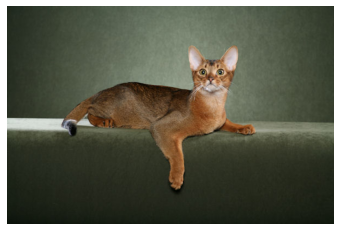

In [7]:
img = Image.open(img_path).convert("RGB")
print(np.array(img).shape)
plt.imshow(img)
plt.grid(False)
plt.axis('off')
plt.show()

(400, 600)


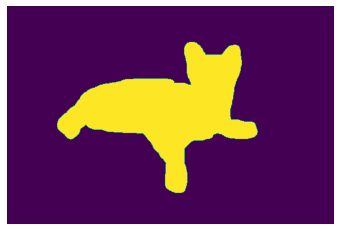

In [8]:
def preprocess_mask(mask):
    mask = mask.astype(np.float32)
    mask[mask == 2.0] = 0.0
    mask[(mask == 1.0) | (mask == 3.0)] = 1.0
    return mask
    
trimap = np.array(Image.open(mask_path))
masks = preprocess_mask(trimap)
print(masks.shape)
plt.imshow(masks)
plt.grid(False)
plt.axis('off')
plt.show()

## Load Datasets

In [9]:
import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks/ADL Group Project')

In [12]:
transform = transforms.Compose([transforms.Resize((512,512)), 
                                transforms.ToTensor(),
                                transforms.Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5))])

transform_y = transforms.Compose([transforms.Resize((512,512)), 
                                  transforms.ToTensor()])

In [13]:
X = []
count = 0
image_names = []
for file_name in tqdm(os.listdir(sys.path[-1]+'/sample dataset/images')):
    image_names.append(file_name.split('.')[0])
    if file_name.split('.')[1] != 'jpg':
        continue
    image_path = sys.path[-1]+'/sample dataset/images/'+file_name
    img = Image.open(image_path).convert("RGB")
    x = transform(img)
    X.append(x.unsqueeze(dim=0))
    count += 1
    if count == 150:
        break
X = torch.cat(X, dim=0)
X.shape

 75%|███████▍  | 152/203 [00:07<00:02, 21.17it/s]


torch.Size([150, 3, 512, 512])

In [14]:
Y = []
count = 0
for file_name in tqdm(image_names):
    masks_path = sys.path[-1]+'/sample dataset/trimaps/'+file_name+'.png'
    trimap = np.array(Image.open(masks_path))
    masks = preprocess_mask(trimap)
    y = transform_y(Image.fromarray((masks).astype(np.uint8)))
    y[y != 0] = 1
    Y.append(y.unsqueeze(dim=0))
    count += 1
    if count == 150:
        break
Y = torch.cat(Y, dim=0)
Y.shape

 97%|█████████▋| 149/153 [01:50<00:02,  1.34it/s]


torch.Size([150, 1, 512, 512])

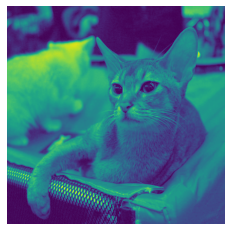

In [15]:
plt.imshow(X[0].squeeze()[0])
plt.grid(False)
plt.axis('off')
plt.show()

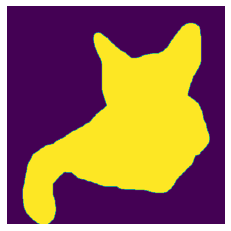

In [16]:
plt.imshow(Y[0].squeeze())
plt.grid(False)
plt.axis('off')
plt.show()

In [17]:
dataset = TensorDataset([X.float(), Y.float()])
train_loader = DataLoader(dataset, batch_size=16, shuffle=True)
print('Datasets ready!')

Datasets ready!


## DeepLab3v+

In [ ]:
model = smp.DeepLabV3Plus(
    encoder_name="resnet50",         # use ResNet50 as backbone
    encoder_weights="imagenet",      # use pre-trained weights from ImageNet
    encoder_depth=5,                 # number of stages used in encoder (default=5, each reduces the feature spatial dimensions by 1/2)
    encoder_output_stride=16,        # 16 for semantic segmentation suggested in the paper for best trade-off between speech and accuracy
    decoder_atrous_rates=(6,12,18),  # dilation rates for ASPP, suggested in the paper
    decoder_channels=256,            # number of convolution filters in ASPP module (default=256)
    in_channels=3,                   # number of input channels (default=3, expects RGB images)
    upsampling=4,                    # final upsampling factor (default=4, to preserve input-output spatial shape identity) 
    activation=None,                 # activation function to apply after the final convolution layer (default=None)
    classes=1,                       # number of segmentation classes
    aux_params=None,                 # parameters of the auxiliary output (defualt=None)
)
model.to(device)

## Dimension Check

In [34]:
x = transform(img)
x = x.unsqueeze(dim=0)
x = x.to(device)
x.shape

torch.Size([1, 3, 512, 512])

In [35]:
model.eval()
with torch.no_grad():
    outputs = model(x)
outputs.shape

torch.Size([1, 1, 512, 512])

In [29]:
outputs = outputs.detach().cpu().numpy().squeeze()
outputs.shape

(512, 512)

## Training

In [ ]:
lr = 1e-4
num_epochs = 20
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

for epoch in range(num_epochs):
    model.train()
    train_loss_i = 0.0
    for images, masks in tqdm(train_loader):
        images, masks = images.to(device), masks.to(device)
        outputs = model(images)
        loss = criterion(outputs.squeeze(), masks.squeeze())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss_i += loss.item()
    print('Training loss: {}'.format(train_loss_i/len(train_loader.dataset)))

# torch.save(model.state_dict(), 'trained_model.pth')

100%|██████████| 10/10 [00:03<00:00,  2.97it/s]


Training loss: 0.04591064572334289


100%|██████████| 10/10 [00:03<00:00,  3.04it/s]


Training loss: 0.035264442364374794


100%|██████████| 10/10 [00:03<00:00,  3.04it/s]


Training loss: 0.027616810401280723


100%|██████████| 10/10 [00:03<00:00,  3.03it/s]


Training loss: 0.02269960363705953


100%|██████████| 10/10 [00:03<00:00,  3.02it/s]


Training loss: 0.01959184487660726


100%|██████████| 10/10 [00:03<00:00,  3.02it/s]


Training loss: 0.017868430813153584


100%|██████████| 10/10 [00:03<00:00,  2.99it/s]


Training loss: 0.016790825327237448


100%|██████████| 10/10 [00:03<00:00,  3.00it/s]


Training loss: 0.015493482947349549


100%|██████████| 10/10 [00:03<00:00,  2.99it/s]


Training loss: 0.01472104956706365


100%|██████████| 10/10 [00:03<00:00,  2.98it/s]


Training loss: 0.013656136890252432


100%|██████████| 10/10 [00:03<00:00,  2.97it/s]


Training loss: 0.012568150162696839


100%|██████████| 10/10 [00:03<00:00,  2.93it/s]


Training loss: 0.011779303252696991


100%|██████████| 10/10 [00:03<00:00,  2.95it/s]


Training loss: 0.011450985968112946


100%|██████████| 10/10 [00:03<00:00,  2.93it/s]


Training loss: 0.011087159315745035


100%|██████████| 10/10 [00:03<00:00,  2.91it/s]


Training loss: 0.010037504434585572


100%|██████████| 10/10 [00:03<00:00,  2.91it/s]


Training loss: 0.009400841196378072


100%|██████████| 10/10 [00:03<00:00,  2.91it/s]


Training loss: 0.009142553359270096


100%|██████████| 10/10 [00:03<00:00,  2.91it/s]


Training loss: 0.008516794790824254


100%|██████████| 10/10 [00:03<00:00,  2.91it/s]


Training loss: 0.008702862858772278


100%|██████████| 10/10 [00:03<00:00,  2.89it/s]

Training loss: 0.008861030042171479


In [ ]:
# torch.save(model.state_dict(), 'trained_model.pth')

## Inference

In [ ]:
x = X[5].unsqueeze(dim=0).to(device)
x.shape

torch.Size([1, 3, 256, 256])

In [ ]:
model.eval()
with torch.no_grad():
    output = model(x)
output.shape

torch.Size([1, 1, 512, 512])

In [ ]:
output = output.detach().cpu().numpy().squeeze()
print(output.shape)

(512, 512)


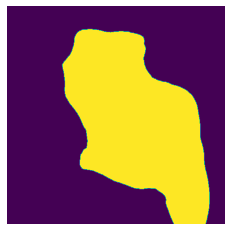

In [ ]:
output[output >= 0.5] = 1
output[output < 0.5] = 0
np.unique(output)

plt.imshow(output)
plt.grid(False)
plt.axis('off')
plt.show()

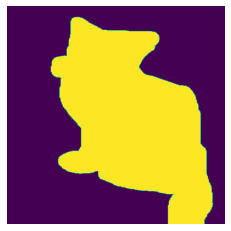

In [ ]:
plt.imshow(Y[5].squeeze())
plt.grid(False)
plt.axis('off')
plt.show()

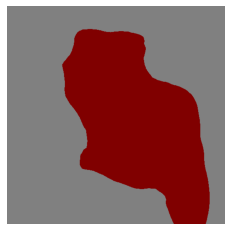

In [ ]:
colors = [(128, 128, 128), (128, 0, 0)]

segmentation = output
segmentation_colored = np.zeros((segmentation.shape[0], segmentation.shape[1], 3), dtype=np.uint8)

for class_index in range(len(colors)):
    segmentation_colored[segmentation==class_index, :] = colors[class_index]

pred_mask = Image.fromarray(segmentation_colored)
plt.imshow(pred_mask)
plt.grid(False)
plt.axis('off')
plt.show()